1- Import XRay Images


In [1]:
import os 
import cv2
import numpy as np 
# traitement dataframe
import pandas as pdœ
# permet de faire des graphiques
import matplotlib.pyplot as plt
import os

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.model_selection import cross_validate


# Analyse du dataset

Le dataset est composé de 3 dossiers : train, val et test. Chaque dossier contient 2 sous-dossiers : NORMAL et PNEUMONIA. Les données sont classées en NORMAL et PNEUMONIA. Les iamges sont en niveaux de gris. Nous avons donc un problème de classification binaire. L'objectif est de prédire si une personne est atteinte de pneumonie ou non.

In [31]:
images_path = './chest_Xray'
subfolders = ["train","val","test"]
categories = ["NORMAL","PNEUMONIA"]
data = {}

for subfolder in subfolders:
    data[subfolder] = {"x":[],"y":[]}
    for category in categories:
        # pour avoir tous les chemins des 6 dossiers
        folder_path = os.path.join(images_path,subfolder,category)
        # liste de toutes les images
        images_files = os.listdir(folder_path)
        imgs = []
        smallest_img_shape = None
        smallest_img_path = None
        for file_name in images_files:
            image_path = os.path.join(folder_path,file_name)
            img = cv2.imread(image_path,cv2.IMREAD_GRAYSCALE)
            imgs.append(img.shape)
            if img is not None:
                if smallest_img_shape is None or (img.shape[0]*img.shape[1] < smallest_img_shape[0]*smallest_img_shape[1]):
                    smallest_img_shape = img.shape
                    smallest_img_path = image_path
        print("L'image la plus petite de {} a une taille de {} et se trouve à {}".format(folder_path, smallest_img_shape, smallest_img_path))
        # print("Tailles des premières images de {} : {}".format(folder_path,imgs))

L'image la plus petite de ./chest_Xray\train\NORMAL a une taille de (672, 912) et se trouve à ./chest_Xray\train\NORMAL\NORMAL2-IM-1356-0001.jpeg
L'image la plus petite de ./chest_Xray\train\PNEUMONIA a une taille de (127, 384) et se trouve à ./chest_Xray\train\PNEUMONIA\person407_virus_811.jpeg
L'image la plus petite de ./chest_Xray\val\NORMAL a une taille de (928, 1288) et se trouve à ./chest_Xray\val\NORMAL\NORMAL2-IM-1436-0001.jpeg
L'image la plus petite de ./chest_Xray\val\PNEUMONIA a une taille de (592, 968) et se trouve à ./chest_Xray\val\PNEUMONIA\person1946_bacteria_4874.jpeg
L'image la plus petite de ./chest_Xray\test\NORMAL a une taille de (496, 984) et se trouve à ./chest_Xray\test\NORMAL\NORMAL2-IM-0256-0001.jpeg
L'image la plus petite de ./chest_Xray\test\PNEUMONIA a une taille de (368, 728) et se trouve à ./chest_Xray\test\PNEUMONIA\person78_bacteria_378.jpeg


2- Class XrayLoader

In [4]:
class XrayLoader:
    def __init__(self, data_folder, image_size):
        self.x_train = None
        self.y_train = None
        self.x_val = None
        self.y_val = None
        self.x_test = None
        self.y_test = None
        self.data_folder = data_folder
        self.image_size = image_size

    def load_data(self):
        subfolders = ["train","val","test"]
        categories = ["NORMAL","PNEUMONIA"]
        data = {}

        for subfolder in subfolders:
            data[subfolder] = {"x":[],"y":[]}
            for category in categories:
                # pour avoir tous les chemins des 6 dossiers
                folder_path = os.path.join(self.data_folder,subfolder,category)
                # liste de toutes les images
                images_files = os.listdir(folder_path)
                for file_name in images_files:
                    image_path = os.path.join(folder_path,file_name)
                    img = cv2.imread(image_path,cv2.IMREAD_GRAYSCALE)
                    if img is not None:
                        img = cv2.resize(img,self.image_size)
                        data[subfolder]["x"].append(img)
                        data[subfolder]["y"].append(category)
                    else:
                        print(f"Image at {image_path} could not be read.")
                
        self.x_train = np.array(data["train"]["x"])
        self.y_train = data["train"]["y"]
        self.x_val = np.array(data["val"]["x"])
        self.y_val = data["val"]["y"]
        self.x_test = np.array(data["test"]["x"])
        self.y_test = data["test"]["y"]

    def display_image(self,dataset,index):
        if dataset == 'train':
            image = self.x_train[index]
            label = self.y_train[index]
            
        elif dataset == 'test':
            image = self.x_test[index]
            label = self.y_test[index]
        else:
            raise ValueError('Invalid dataset. Choose either "train" or "test".')

        plt.imshow(image,cmap="gray")
        plt.title(f'Image {index} - Catégorie: {label}')
        plt.axis('off')
        plt.show()
    
    def display_category_means(self):
        normal_mean = self.calculate_category_mean(self.x_train, self.y_train, "NORMAL")
        pneumonia_mean = self.calculate_category_mean(self.x_train, self.y_train, "PNEUMONIA")

        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(normal_mean, cmap="gray")
        plt.title("Mean NORMAL Image")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(pneumonia_mean, cmap="gray")
        plt.title("Mean PNEUMONIA Image")
        plt.axis("off")

        plt.tight_layout()
        plt.show()

    @staticmethod
    def calculate_category_mean(images, labels, category):
        images = np.array(images)
        labels = np.array(labels)
        category_images = images[labels == category]
        mean_image = np.mean(category_images, axis=0)
        return mean_image
    
    def display_distribution(self):
        test = ( self.y_test.count("NORMAL"), self.y_test.count("PNEUMONIA") )
        train = ( self.y_train.count("NORMAL"), self.y_train.count("PNEUMONIA") )
        val = ( self.y_val.count("NORMAL"), self.y_val.count("PNEUMONIA") )
        
        # Tracer les graphiques de distribution
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        ax[0].bar(["NORMAL", "PNEUMONIA"], train)
        ax[0].set_title("Train Distribution")
        ax[1].bar(["NORMAL", "PNEUMONIA"], val)
        ax[1].set_title("Validation Distribution")
        ax[2].bar(["NORMAL", "PNEUMONIA"], test)
        ax[2].set_title("Test Distribution")
        plt.show()
    


In [5]:
loader = XrayLoader(data_folder='./chest_Xray', image_size=(800, 800))
loader.load_data()
xtrain = loader.x_train
ytrain = loader.y_train
xtest = loader.x_test
ytest = loader.y_test
xval = loader.x_val
yval = loader.y_val

Image at ./chest_Xray\train\NORMAL\.DS_Store could not be read.
Image at ./chest_Xray\train\PNEUMONIA\.DS_Store could not be read.
Image at ./chest_Xray\val\NORMAL\.DS_Store could not be read.
Image at ./chest_Xray\val\PNEUMONIA\.DS_Store could not be read.


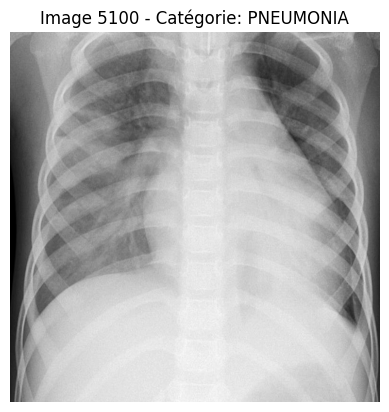

In [6]:
loader.display_image("train",5100)

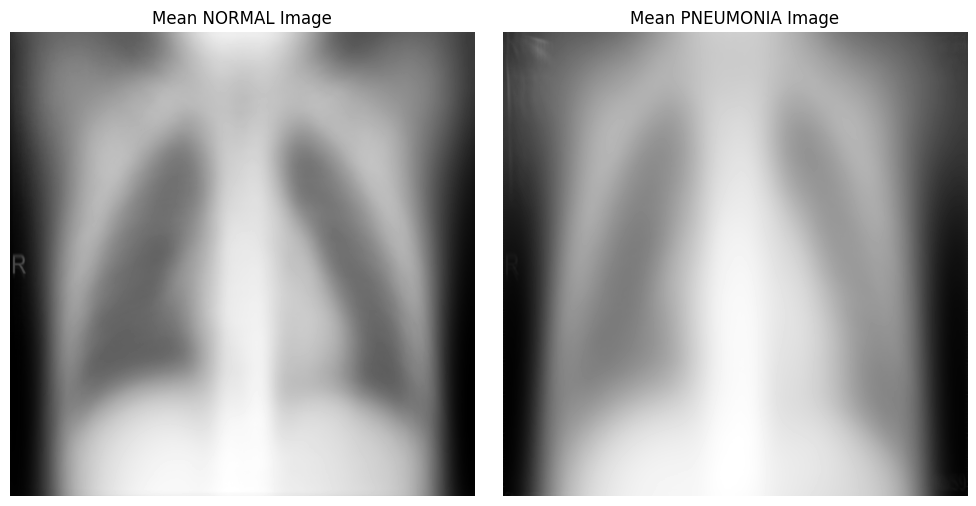

In [7]:
loader.display_category_means()

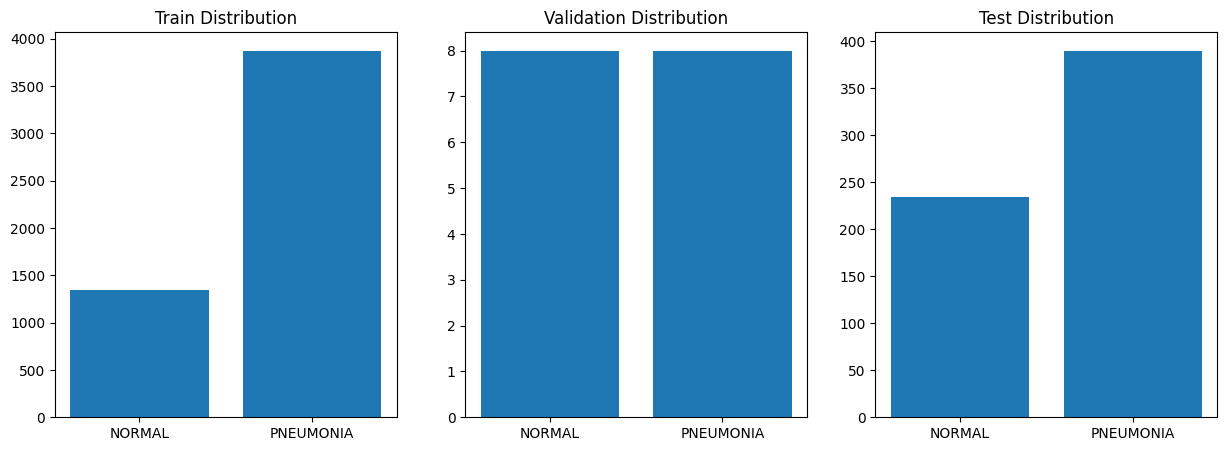

In [8]:
loader.display_distribution()